# 1~10번 Cell

- Cell 1: 라이브러리 임포트 및 모델 정의.
- Cell 2: 데이터 로드 및 전처리.
- Cell 3: 학습 환경 설정 및 옵티마이저 정의.
- Cell 4: Feature Extraction 및 평가 함수 정의.
- Cell 5: 메인 학습 루프 (모델 학습, 검증, 저장, 평가).
- Cell 6: Latent Classifier 정의.
- Cell 7: Latent Feature 추출 및 TensorDataset 변환.
- Cell 8: Latent Classifier 학습.
- Cell 9: 저장된 모델 가중치 불러오기.
- Cell 10: Latent Feature를 사용한 추가 분석

In [1]:
# Cell 1: 라이브러리 임포트 및 BaseModel 정의
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


# BaseModel 정의
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv1_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        
        self.conv2_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        
        self.conv3_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.conv4_M = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        
        self.GAP = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_M(out)
        
        out = self.conv2(out)
        out = self.conv2_M(out)
        
        out = self.conv3(out)
        out = self.conv3_M(out)
        
        out = self.conv4(out)
        out = self.conv4_M(out)
        
        out = self.conv5(out)
        out = self.GAP(out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [8]:
class PadToSquare(object):
    """이미지 크기를 최대 크기로 패딩하여 정사각형으로 만듭니다."""
    def __init__(self, padding_value=0):
        self.padding_value = padding_value
        self.to_tensor = transforms.ToTensor()  # PIL 이미지 -> Tensor
        self.to_pil = transforms.ToPILImage()  # Tensor -> PIL 이미지

    def __call__(self, image):
        # PIL 이미지를 텐서로 변환
        image_tensor = self.to_tensor(image)

        # 현재 이미지 크기 가져오기
        _, height, width = image_tensor.shape
        max_size = max(height, width)

        # 패딩 계산 (좌, 상, 우, 하)
        padding = (0, 0, max_size - width, max_size - height)  # (left, top, right, bottom)

        # 패딩 추가 (텐서에 패딩)
        padded_tensor = F.pad(image_tensor, padding, value=self.padding_value)

        # 텐서를 다시 PIL 이미지로 변환
        padded_image = self.to_pil(padded_tensor)
        return padded_image

# 데이터 디렉토리 설정
train_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/train'
test_dir = '/home/gidaseul/Documents/GitHub/ML_2/datas/SportsBall/test'

# 데이터 전처리: MNIST 이미지를 RGB 채널로 처리
transform = transforms.Compose([
    PadToSquare(),  # 이미지 크기를 가장 큰 크기로 맞추기 위해 패딩
    transforms.Resize((228, 228)),
    transforms.ToTensor(),        # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# 데이터셋 크기 확인
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# 데이터 클래스 확인
print(f"Classes: {train_dataset.classes}")


Number of training samples: 1000
Number of test samples: 100
Classes: ['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'football', 'golf_ball', 'shuttlecock', 'tennis_ball', 'volleyball']


In [3]:
# Cell 3: 학습 환경 설정 및 옵티마이저 정의

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BaseModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 조기 종료 파라미터 설정
early_stopping_patience = 10  # 개선되지 않으면 10 에폭 후 종료
best_test_loss = float('inf')  # 최적의 검증 손실
patience_counter = 0  # 개선되지 않은 에폭 수 카운트

# 모델 가중치 저장을 위한 경로
save_path = 'sportsball_weights.pth'


Using device: cuda


In [4]:
# Cell 4: Feature Extraction 및 평가 함수 정의

def extract_features(model, loader, device):
    features, labels_list = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Conv-Blocks 통과
            out = model.conv1(images)
            out = model.conv1_M(out)

            out = model.conv2(out)
            out = model.conv2_M(out)

            out = model.conv3(out)
            out = model.conv3_M(out)

            out = model.conv4(out)
            out = model.conv4_M(out)

            out = model.conv5(out)
            out = model.GAP(out)
            latent = out.view(out.size(0), -1)

            features.append(latent.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

            # 메모리 정리
            del images, labels, out, latent
            torch.cuda.empty_cache()

    features = np.concatenate(features, axis=0)
    return features, np.array(labels_list)

def plot_tsne(features, labels, num_classes=10):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for class_idx in range(num_classes):
        idx = labels == class_idx
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f'Class {class_idx}', alpha=0.6)
    plt.legend()
    plt.title("t-SNE Visualization of Features")
    plt.show()


Epoch [1/100]
Train Loss: 2.3208, Train Acc: 14.50%
Test Loss: 3.5266, Test Acc: 12.00%
Model weights saved.
Epoch [2/100]
Train Loss: 2.1542, Train Acc: 18.10%
Test Loss: 2.9332, Test Acc: 18.00%
Model weights saved.
Epoch [3/100]
Train Loss: 2.1288, Train Acc: 21.50%
Test Loss: 2.2394, Test Acc: 16.00%
Model weights saved.
Epoch [4/100]
Train Loss: 2.0549, Train Acc: 22.00%
Test Loss: 2.1188, Test Acc: 21.00%
Model weights saved.
Epoch [5/100]
Train Loss: 2.0900, Train Acc: 25.20%
Test Loss: 2.2081, Test Acc: 20.00%
Patience Counter: 1/10
Extracting features for t-SNE and clustering metrics...


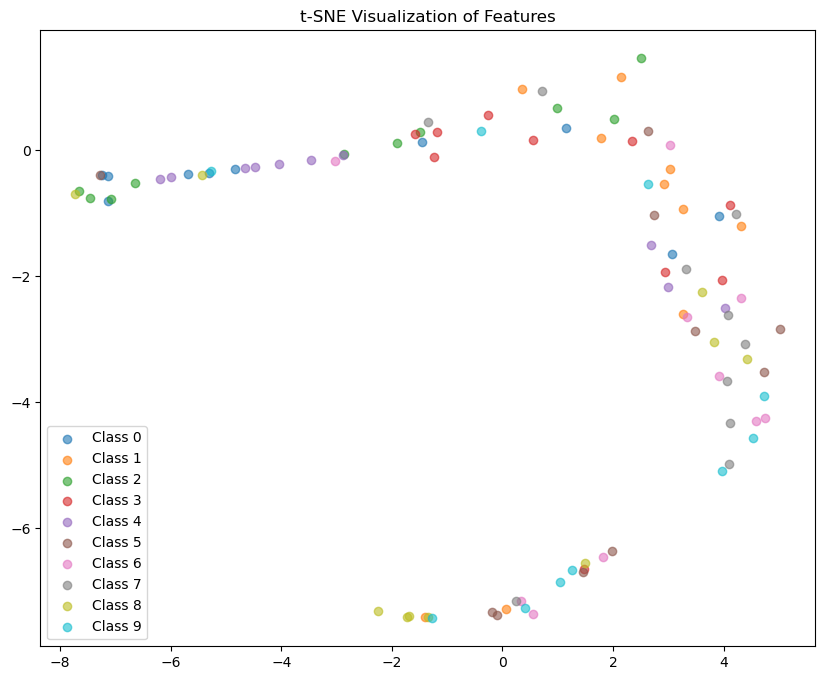

Silhouette Score: -0.3166, Davies-Bouldin Index: 13.9458
Epoch [6/100]
Train Loss: 2.0276, Train Acc: 24.90%
Test Loss: 2.4373, Test Acc: 13.00%
Patience Counter: 2/10
Epoch [7/100]
Train Loss: 1.9830, Train Acc: 25.20%
Test Loss: 2.0572, Test Acc: 23.00%
Model weights saved.
Epoch [8/100]
Train Loss: 2.0439, Train Acc: 25.40%
Test Loss: 2.0493, Test Acc: 21.00%
Model weights saved.
Epoch [9/100]
Train Loss: 1.9776, Train Acc: 26.10%
Test Loss: 2.1918, Test Acc: 22.00%
Patience Counter: 1/10
Epoch [10/100]
Train Loss: 2.0459, Train Acc: 26.50%
Test Loss: 1.9485, Test Acc: 26.00%
Model weights saved.
Extracting features for t-SNE and clustering metrics...


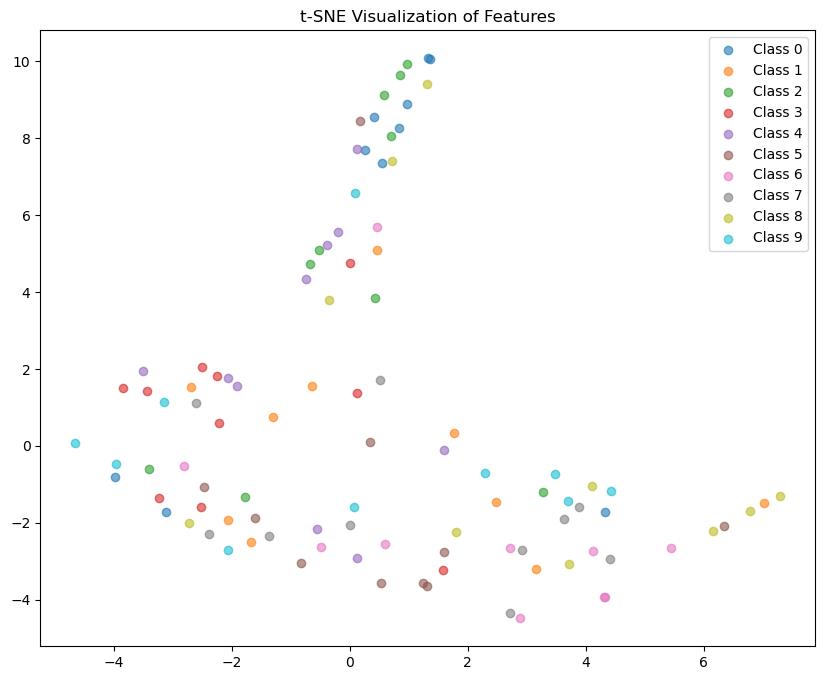

Silhouette Score: -0.2651, Davies-Bouldin Index: 4.3653
Epoch [11/100]
Train Loss: 1.9622, Train Acc: 27.70%
Test Loss: 2.0666, Test Acc: 26.00%
Patience Counter: 1/10
Epoch [12/100]
Train Loss: 1.9725, Train Acc: 27.10%
Test Loss: 1.9713, Test Acc: 20.00%
Patience Counter: 2/10
Epoch [13/100]
Train Loss: 1.9341, Train Acc: 29.80%
Test Loss: 1.9063, Test Acc: 24.00%
Model weights saved.
Epoch [14/100]
Train Loss: 1.9276, Train Acc: 30.70%
Test Loss: 1.9190, Test Acc: 27.00%
Patience Counter: 1/10
Epoch [15/100]
Train Loss: 1.9136, Train Acc: 29.00%
Test Loss: 2.0860, Test Acc: 25.00%
Patience Counter: 2/10
Extracting features for t-SNE and clustering metrics...


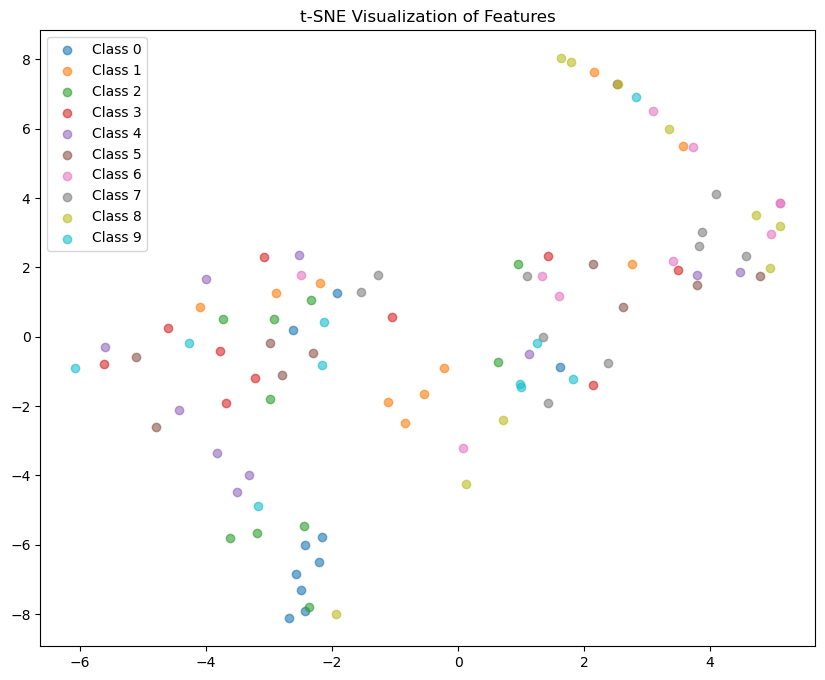

Silhouette Score: -0.2065, Davies-Bouldin Index: 4.0384
Epoch [16/100]
Train Loss: 1.8876, Train Acc: 32.40%
Test Loss: 2.2405, Test Acc: 22.00%
Patience Counter: 3/10
Epoch [17/100]
Train Loss: 1.8923, Train Acc: 32.50%
Test Loss: 1.7750, Test Acc: 27.00%
Model weights saved.
Epoch [18/100]
Train Loss: 1.8283, Train Acc: 35.90%
Test Loss: 1.7726, Test Acc: 27.00%
Model weights saved.
Epoch [19/100]
Train Loss: 1.8433, Train Acc: 34.00%
Test Loss: 2.3980, Test Acc: 22.00%
Patience Counter: 1/10
Epoch [20/100]
Train Loss: 1.8232, Train Acc: 35.40%
Test Loss: 1.9156, Test Acc: 27.00%
Patience Counter: 2/10
Extracting features for t-SNE and clustering metrics...


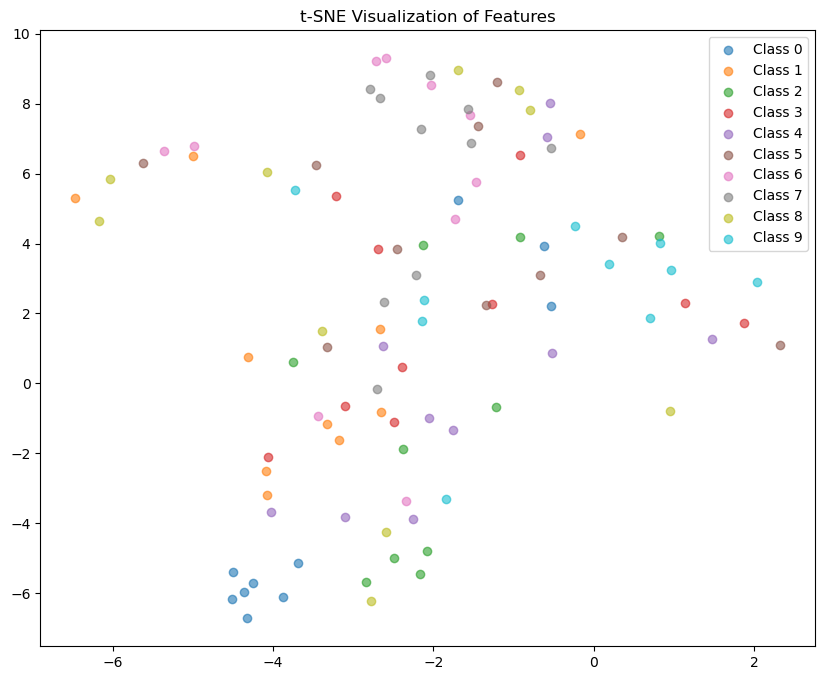

Silhouette Score: -0.1664, Davies-Bouldin Index: 3.3677
Epoch [21/100]
Train Loss: 1.7870, Train Acc: 37.70%
Test Loss: 1.7078, Test Acc: 33.00%
Model weights saved.
Epoch [22/100]
Train Loss: 1.7784, Train Acc: 38.20%
Test Loss: 2.2716, Test Acc: 32.00%
Patience Counter: 1/10
Epoch [23/100]
Train Loss: 1.7699, Train Acc: 40.40%
Test Loss: 2.0739, Test Acc: 24.00%
Patience Counter: 2/10
Epoch [24/100]
Train Loss: 1.7272, Train Acc: 39.20%
Test Loss: 2.5215, Test Acc: 26.00%
Patience Counter: 3/10
Epoch [25/100]
Train Loss: 1.7297, Train Acc: 41.40%
Test Loss: 1.6873, Test Acc: 34.00%
Model weights saved.
Extracting features for t-SNE and clustering metrics...


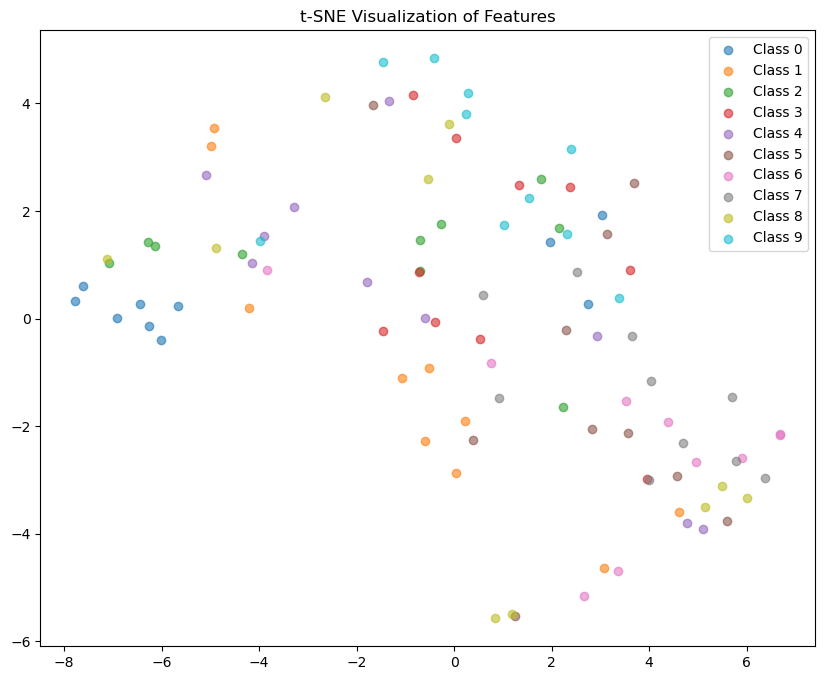

Silhouette Score: -0.1868, Davies-Bouldin Index: 3.5522
Epoch [26/100]
Train Loss: 1.7212, Train Acc: 40.20%
Test Loss: 2.2264, Test Acc: 28.00%
Patience Counter: 1/10
Epoch [27/100]
Train Loss: 1.7305, Train Acc: 39.00%
Test Loss: 1.6959, Test Acc: 30.00%
Patience Counter: 2/10
Epoch [28/100]
Train Loss: 1.6442, Train Acc: 40.60%
Test Loss: 1.6338, Test Acc: 41.00%
Model weights saved.
Epoch [29/100]
Train Loss: 1.6831, Train Acc: 41.10%
Test Loss: 1.6207, Test Acc: 34.00%
Model weights saved.
Epoch [30/100]
Train Loss: 1.6312, Train Acc: 42.20%
Test Loss: 2.0030, Test Acc: 30.00%
Patience Counter: 1/10
Extracting features for t-SNE and clustering metrics...


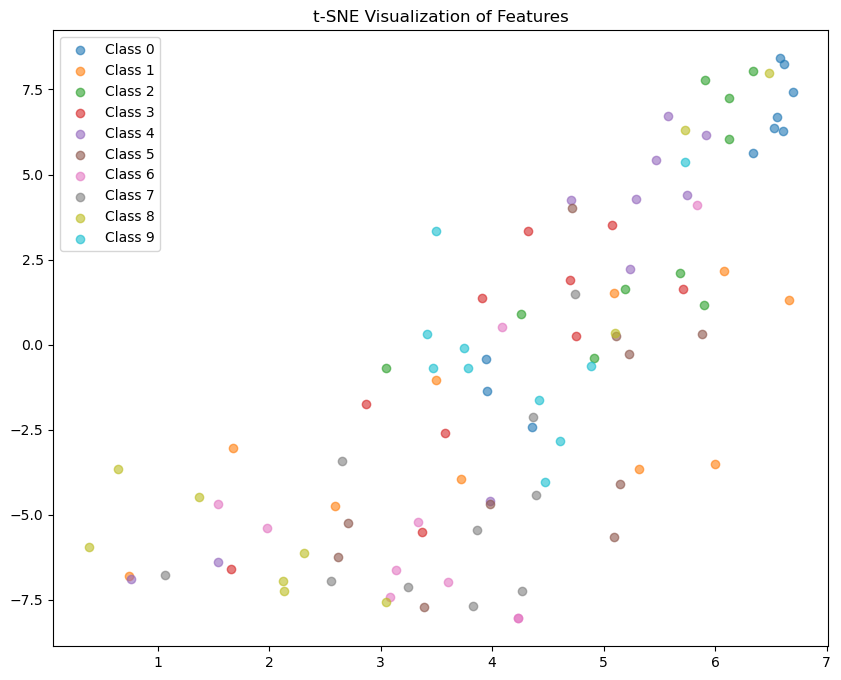

Silhouette Score: -0.2055, Davies-Bouldin Index: 4.4580
Epoch [31/100]
Train Loss: 1.6186, Train Acc: 42.80%
Test Loss: 1.6439, Test Acc: 32.00%
Patience Counter: 2/10
Epoch [32/100]
Train Loss: 1.6812, Train Acc: 40.70%
Test Loss: 2.0882, Test Acc: 26.00%
Patience Counter: 3/10
Epoch [33/100]
Train Loss: 1.6799, Train Acc: 42.90%
Test Loss: 1.7017, Test Acc: 37.00%
Patience Counter: 4/10
Epoch [34/100]
Train Loss: 1.5904, Train Acc: 44.50%
Test Loss: 1.6442, Test Acc: 38.00%
Patience Counter: 5/10
Epoch [35/100]
Train Loss: 1.5228, Train Acc: 46.80%
Test Loss: 1.6545, Test Acc: 33.00%
Patience Counter: 6/10
Extracting features for t-SNE and clustering metrics...


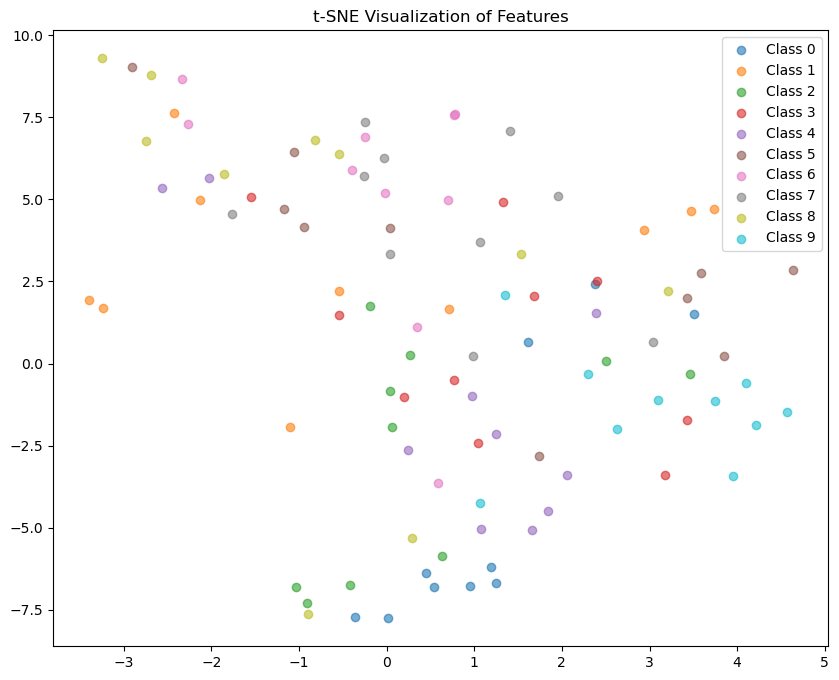

Silhouette Score: -0.1578, Davies-Bouldin Index: 3.5869
Epoch [36/100]
Train Loss: 1.5236, Train Acc: 49.10%
Test Loss: 1.4993, Test Acc: 36.00%
Model weights saved.
Epoch [37/100]
Train Loss: 1.4903, Train Acc: 49.60%
Test Loss: 1.5894, Test Acc: 34.00%
Patience Counter: 1/10
Epoch [38/100]
Train Loss: 1.4560, Train Acc: 51.10%
Test Loss: 1.4969, Test Acc: 41.00%
Model weights saved.
Epoch [39/100]
Train Loss: 1.4267, Train Acc: 51.10%
Test Loss: 1.5044, Test Acc: 37.00%
Patience Counter: 1/10
Epoch [40/100]
Train Loss: 1.4251, Train Acc: 48.60%
Test Loss: 1.4457, Test Acc: 41.00%
Model weights saved.
Extracting features for t-SNE and clustering metrics...


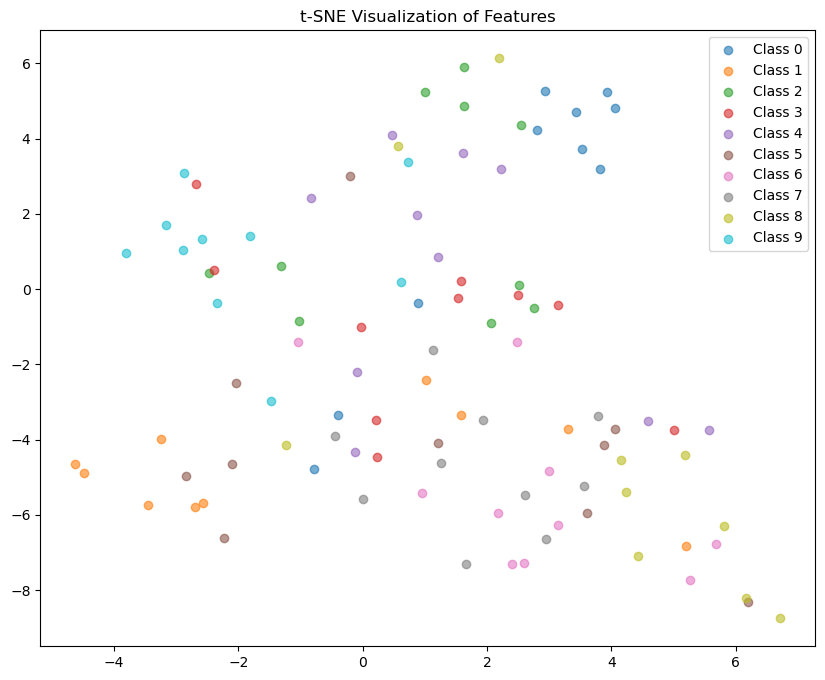

Silhouette Score: -0.1312, Davies-Bouldin Index: 3.2423
Epoch [41/100]
Train Loss: 1.4296, Train Acc: 50.70%
Test Loss: 1.5666, Test Acc: 40.00%
Patience Counter: 1/10
Epoch [42/100]
Train Loss: 1.4324, Train Acc: 50.30%
Test Loss: 1.5156, Test Acc: 41.00%
Patience Counter: 2/10
Epoch [43/100]
Train Loss: 1.3511, Train Acc: 54.60%
Test Loss: 1.3378, Test Acc: 44.00%
Model weights saved.
Epoch [44/100]
Train Loss: 1.4312, Train Acc: 51.50%
Test Loss: 1.7064, Test Acc: 36.00%
Patience Counter: 1/10
Epoch [45/100]
Train Loss: 1.4213, Train Acc: 49.80%
Test Loss: 1.6049, Test Acc: 37.00%
Patience Counter: 2/10
Extracting features for t-SNE and clustering metrics...


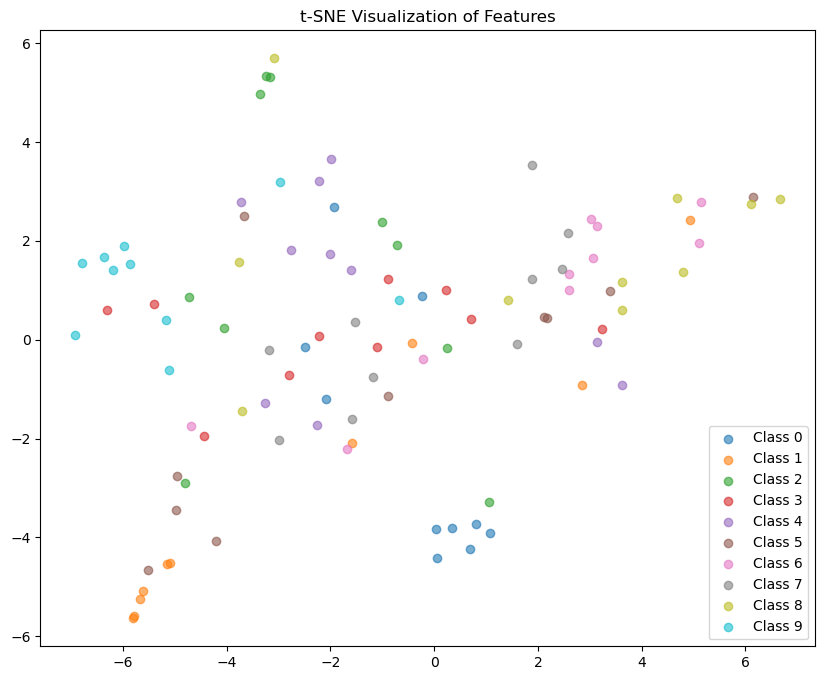

Silhouette Score: -0.1104, Davies-Bouldin Index: 3.1709
Epoch [46/100]
Train Loss: 1.3757, Train Acc: 50.90%
Test Loss: 1.4154, Test Acc: 42.00%
Patience Counter: 3/10
Epoch [47/100]
Train Loss: 1.3909, Train Acc: 51.80%
Test Loss: 1.3494, Test Acc: 42.00%
Patience Counter: 4/10
Epoch [48/100]
Train Loss: 1.3259, Train Acc: 54.20%
Test Loss: 1.2700, Test Acc: 49.00%
Model weights saved.
Epoch [49/100]
Train Loss: 1.2373, Train Acc: 59.20%
Test Loss: 1.3676, Test Acc: 43.00%
Patience Counter: 1/10
Epoch [50/100]
Train Loss: 1.2414, Train Acc: 59.30%
Test Loss: 1.2983, Test Acc: 46.00%
Patience Counter: 2/10
Extracting features for t-SNE and clustering metrics...


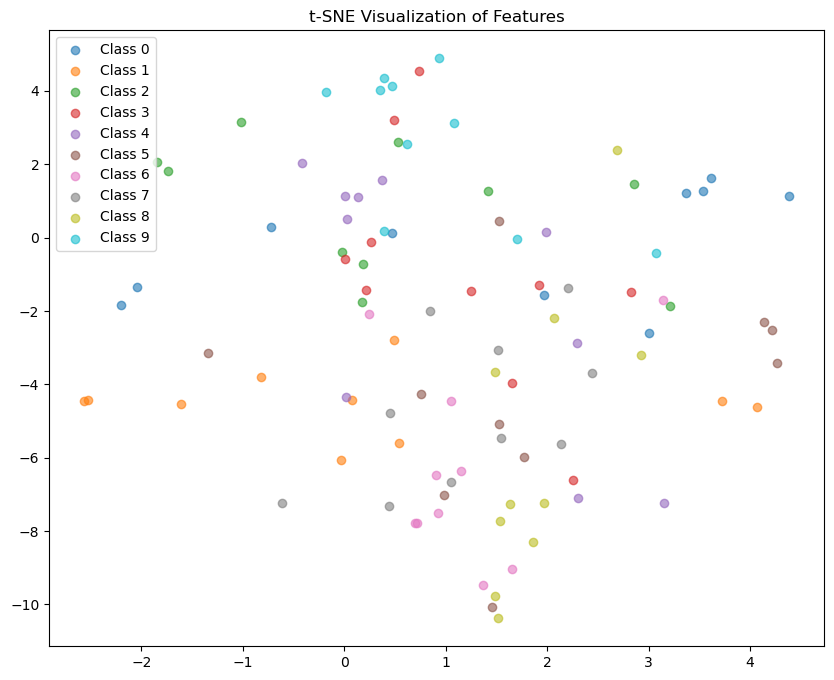

Silhouette Score: -0.0921, Davies-Bouldin Index: 3.1954
Epoch [51/100]
Train Loss: 1.1955, Train Acc: 59.20%
Test Loss: 1.3642, Test Acc: 41.00%
Patience Counter: 3/10
Epoch [52/100]
Train Loss: 1.2008, Train Acc: 60.10%
Test Loss: 1.2968, Test Acc: 42.00%
Patience Counter: 4/10
Epoch [53/100]
Train Loss: 1.1590, Train Acc: 62.30%
Test Loss: 1.3034, Test Acc: 43.00%
Patience Counter: 5/10
Epoch [54/100]
Train Loss: 1.1307, Train Acc: 62.30%
Test Loss: 1.3170, Test Acc: 43.00%
Patience Counter: 6/10
Epoch [55/100]
Train Loss: 1.1066, Train Acc: 64.00%
Test Loss: 1.3382, Test Acc: 48.00%
Patience Counter: 7/10
Extracting features for t-SNE and clustering metrics...


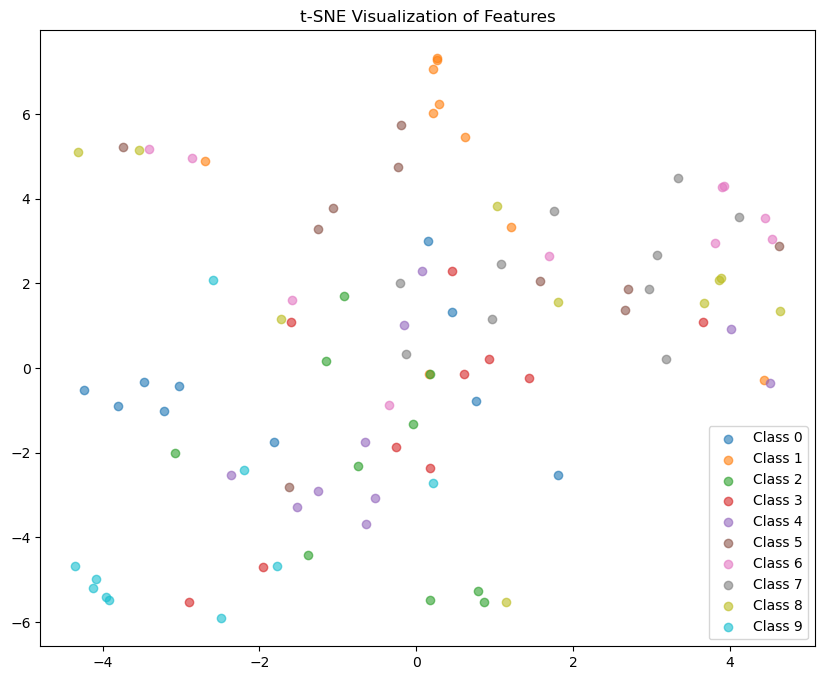

Silhouette Score: -0.0843, Davies-Bouldin Index: 3.1151
Epoch [56/100]
Train Loss: 1.0768, Train Acc: 64.90%
Test Loss: 1.3887, Test Acc: 45.00%
Patience Counter: 8/10
Epoch [57/100]
Train Loss: 1.0835, Train Acc: 63.70%
Test Loss: 1.2544, Test Acc: 49.00%
Model weights saved.
Epoch [58/100]
Train Loss: 1.0186, Train Acc: 67.70%
Test Loss: 1.4099, Test Acc: 43.00%
Patience Counter: 1/10
Epoch [59/100]
Train Loss: 0.9811, Train Acc: 69.20%
Test Loss: 1.3661, Test Acc: 44.00%
Patience Counter: 2/10
Epoch [60/100]
Train Loss: 1.0075, Train Acc: 67.50%
Test Loss: 1.4266, Test Acc: 50.00%
Patience Counter: 3/10
Extracting features for t-SNE and clustering metrics...


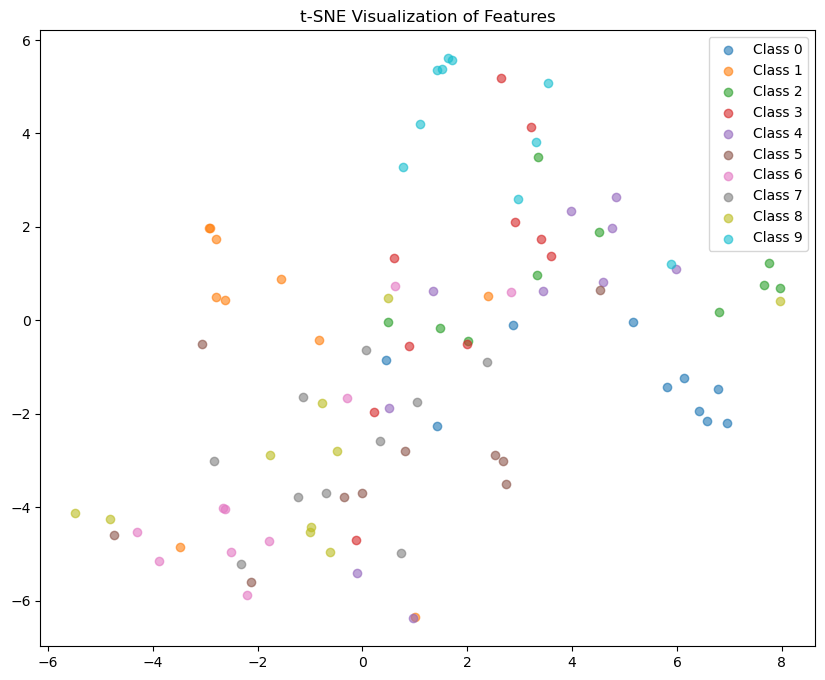

Silhouette Score: -0.0735, Davies-Bouldin Index: 2.8865
Epoch [61/100]
Train Loss: 0.9860, Train Acc: 68.30%
Test Loss: 1.3466, Test Acc: 46.00%
Patience Counter: 4/10
Epoch [62/100]
Train Loss: 0.9523, Train Acc: 69.40%
Test Loss: 1.3469, Test Acc: 46.00%
Patience Counter: 5/10
Epoch [63/100]
Train Loss: 0.9256, Train Acc: 70.00%
Test Loss: 1.3489, Test Acc: 42.00%
Patience Counter: 6/10
Epoch [64/100]
Train Loss: 0.9417, Train Acc: 69.20%
Test Loss: 1.2556, Test Acc: 48.00%
Patience Counter: 7/10
Epoch [65/100]
Train Loss: 0.9366, Train Acc: 70.20%
Test Loss: 1.3836, Test Acc: 44.00%
Patience Counter: 8/10
Extracting features for t-SNE and clustering metrics...


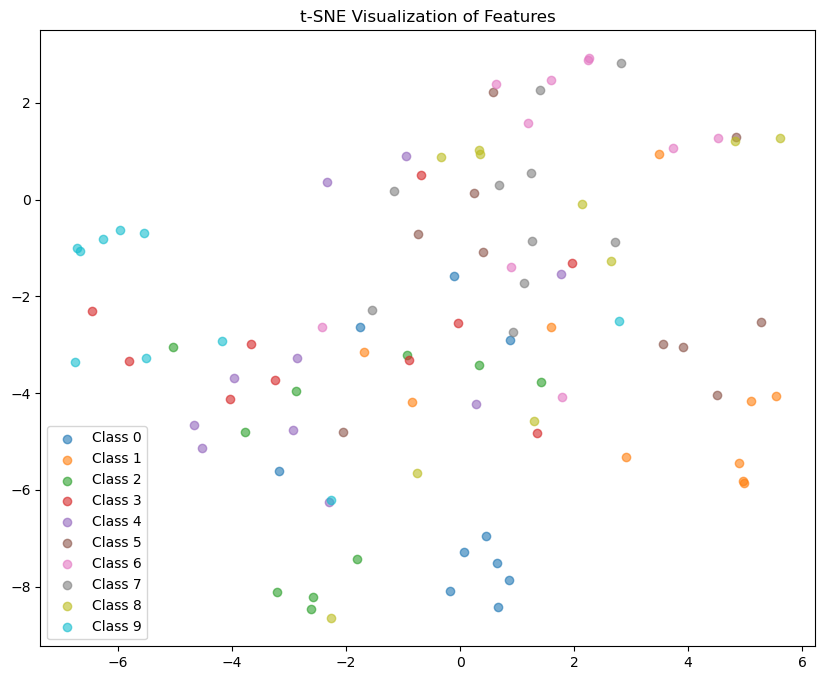

Silhouette Score: -0.0730, Davies-Bouldin Index: 3.1354
Epoch [66/100]
Train Loss: 0.9617, Train Acc: 68.70%
Test Loss: 1.3874, Test Acc: 43.00%
Patience Counter: 9/10
Epoch [67/100]
Train Loss: 0.8788, Train Acc: 72.90%
Test Loss: 1.3634, Test Acc: 44.00%
Patience Counter: 10/10
Early stopping at epoch 67


In [6]:
# Cell 5: 메인 학습 루프

for epoch in range(100):
    # Training Loop
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del images, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Evaluation Loop
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del images, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/100]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # 학습률 조정 (ReduceLROnPlateau 사용)
    scheduler.step(test_loss)

    # test_loss 개선 시 가중치 저장
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # 개선이 있었으므로 카운터 초기화
        torch.save(model.state_dict(), save_path)  # 모델 가중치 저장
        print("Model weights saved.")
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{early_stopping_patience}")

    # Early Stopping 체크
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # 5 에폭마다 t-SNE 시각화 및 군집화 지표 계산
    if (epoch + 1) % 5 == 0:
        print("Extracting features for t-SNE and clustering metrics...")
        test_features, test_labels = extract_features(model, test_loader, device)

        # t-SNE 시각화
        plot_tsne(test_features, test_labels, num_classes=10)

        # Silhouette Score 및 Davies-Bouldin Index 계산
        silhouette = silhouette_score(test_features, test_labels)
        dbi = davies_bouldin_score(test_features, test_labels)
        print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")


In [5]:
# Cell 6: Latent Classifier 정의

# Latent Classifier 정의
class LatentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [8]:
# Cell 7: Latent Feature 추출 및 TensorDataset 변환

# 모델 가중치 로드 (필요 시)
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

# Latent Feature 추출
print("Extracting train features...")
train_features, train_labels = extract_features(model, train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features(model, test_loader, device)

# TensorDataset으로 변환
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset_latent = torch.utils.data.TensorDataset(train_features, train_labels)
test_dataset_latent = torch.utils.data.TensorDataset(test_features, test_labels)

# DataLoader 생성
train_loader_latent = torch.utils.data.DataLoader(train_dataset_latent, batch_size=64, shuffle=True)
test_loader_latent = torch.utils.data.DataLoader(test_dataset_latent, batch_size=64, shuffle=False)

print(f"Number of training latent samples: {len(train_dataset_latent)}")
print(f"Number of test latent samples: {len(test_dataset_latent)}")


Extracting train features...


/tmp/ipykernel_47768/1347501849.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Extracting test features...
Number of training latent samples: 1000
Number of test latent samples: 100


In [9]:
# Cell 8: Latent Classifier 학습

# Latent Classifier 초기화
latent_classifier = LatentClassifier(input_dim=train_features.shape[1], num_classes=10).to(device)
criterion_latent = nn.CrossEntropyLoss()
optimizer_latent = optim.Adam(latent_classifier.parameters(), lr=0.001)

# Latent Classifier 학습 루프
num_epochs = 50
for epoch in range(num_epochs):
    # Training Loop
    latent_classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for features, labels in train_loader_latent:
        features, labels = features.to(device), labels.to(device)

        optimizer_latent.zero_grad()
        outputs = latent_classifier(features)
        loss = criterion_latent(outputs, labels)
        loss.backward()
        optimizer_latent.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 메모리 정리
        del features, labels, outputs, loss
        torch.cuda.empty_cache()

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader_latent)

    # Evaluation Loop
    latent_classifier.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in test_loader_latent:
            features, labels = features.to(device), labels.to(device)
            outputs = latent_classifier(features)
            loss = criterion_latent(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 메모리 정리
            del features, labels, outputs, loss
            torch.cuda.empty_cache()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader_latent)

    print(f"Latent Classifier Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Latent Classifier Epoch [1/50]
Train Loss: 1.7704, Train Acc: 51.80%
Test Loss: 1.5895, Test Acc: 46.00%
Latent Classifier Epoch [2/50]
Train Loss: 1.1259, Train Acc: 67.40%
Test Loss: 1.5015, Test Acc: 44.00%
Latent Classifier Epoch [3/50]
Train Loss: 0.9685, Train Acc: 67.20%
Test Loss: 1.5145, Test Acc: 47.00%
Latent Classifier Epoch [4/50]
Train Loss: 0.8986, Train Acc: 69.60%
Test Loss: 1.5265, Test Acc: 46.00%
Latent Classifier Epoch [5/50]
Train Loss: 0.8856, Train Acc: 70.00%
Test Loss: 1.5717, Test Acc: 46.00%
Latent Classifier Epoch [6/50]
Train Loss: 0.8589, Train Acc: 71.30%
Test Loss: 1.6102, Test Acc: 46.00%
Latent Classifier Epoch [7/50]
Train Loss: 0.8557, Train Acc: 71.20%
Test Loss: 1.5782, Test Acc: 45.00%
Latent Classifier Epoch [8/50]
Train Loss: 0.8485, Train Acc: 71.30%
Test Loss: 1.6295, Test Acc: 44.00%
Latent Classifier Epoch [9/50]
Train Loss: 0.8347, Train Acc: 71.90%
Test Loss: 1.6210, Test Acc: 48.00%
Latent Classifier Epoch [10/50]
Train Loss: 0.8196, Tra

In [12]:
# Cell 9: 저장된 모델 가중치 불러오기 (필요 시)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 가중치 로드
model = BaseModel().to(device)
model.load_state_dict(torch.load('sportsball_weights.pth', map_location=device))
model.eval()

print("Model weights loaded successfully.")


Model weights loaded successfully.


/tmp/ipykernel_9655/1995011951.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sportsball_weights.pth', map_location=device))


/tmp/ipykernel_52234/2388957813.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sportsball_weights.pth'))


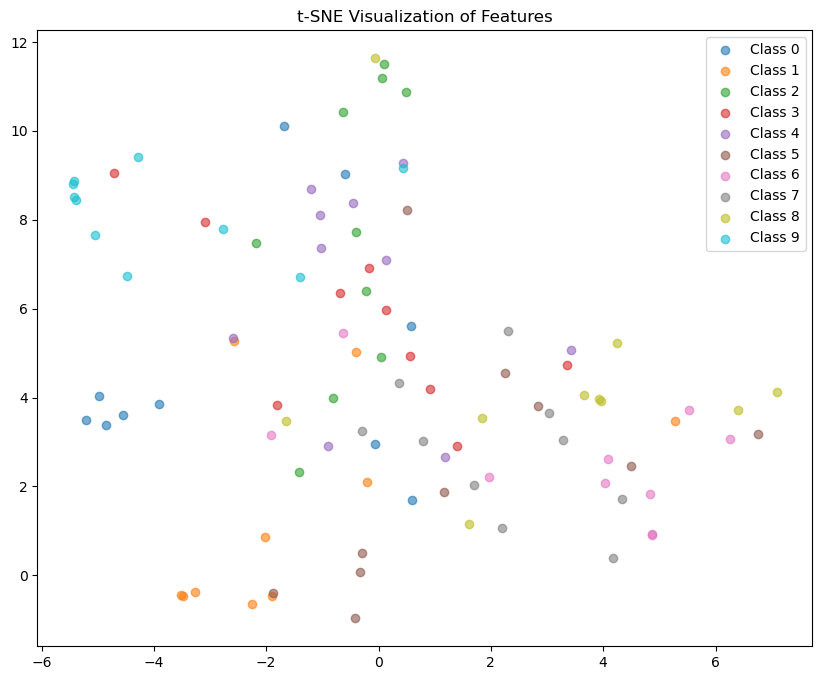

Silhouette Score: -0.0757, Davies-Bouldin Index: 2.9459


In [ ]:
# Cell 10: Latent Feature를 사용한 추가 분석 (예: t-SNE, 분류기 학습 등)
# Latent Feature 추출: 저장된 모델 가중치를 사용하여 테스트 데이터의 Latent Feature를 추출합니다.
# t-SNE 시각화: 추출된 Feature를 2차원으로 축소하여 시각화합니다.
# 군집화 지표 계산: Silhouette Score와 Davies-Bouldin Index를 계산하여 Latent Space의 군집화 품질을 평가합니다.

# 예시: 이미 저장된 모델 가중치를 로드한 후 Latent Feature 추출 및 시각화
# model = BaseModel().to(device)
# model.load_state_dict(torch.load('sportsball_weights.pth'))
# model.eval()

# Latent Feature 추출
test_features, test_labels = extract_features(model, test_loader, device)

# t-SNE 시각화
plot_tsne(test_features, test_labels, num_classes=10)

# 군집화 지표 계산
silhouette = silhouette_score(test_features, test_labels)
dbi = davies_bouldin_score(test_features, test_labels)
print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {dbi:.4f}")


# 11번 부터는 이후 추가적으로 latent space에 대해서 실험
- Cell 11: Contrastive Loss 정의
- Cell 12: Decoder 및 Full Model 정의
- Cell 13: Contrastive Loss + SSL 학습 루프
- Cell 14: 학습 결과 저장 및 최적 모델 가중치 관리
- Cell 15: 학습된 Full Model의 Latent Feature 분석 및 시각화

In [25]:
# Cell 11: Contrastive Loss 정의
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, features, labels):
        # L2 거리 계산
        distances = torch.cdist(features, features, p=2)  # [batch_size, batch_size]

        # 라벨 매트릭스 생성
        label_matrix = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()  # [batch_size, batch_size]

        # 같은 클래스의 샘플 간 거리 최소화
        positive_loss = (label_matrix * distances.pow(2)).mean()

        # 다른 클래스의 샘플 간 거리 유지
        negative_loss = ((1 - label_matrix) * torch.relu(self.margin - distances).pow(2)).mean()

        return positive_loss + negative_loss


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 228 * 228 * 3),  # 복원 이미지 크기를 228x228로 설정
            nn.Sigmoid()  # 데이터를 [0, 1]로 정규화
        )

    def forward(self, x):
        x = self.decoder(x)
        return x.view(x.size(0), 3, 228, 228)  # 복원된 이미지 크기 맞춤


In [ ]:
transform = transforms.Compose([
    transforms.Resize((228, 228)),  # 이미지를 228x228로 리사이즈
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [27]:
# Full Model 정의
class FullModel(nn.Module):
    def __init__(self, base_model, decoder):
        super().__init__()
        self.base_model = base_model
        self.decoder = decoder

    def forward(self, x):
        # Encoder로 Latent Space 추출
        latent = self.base_model.GAP(self.base_model.conv5(
            self.base_model.conv4(self.base_model.conv3(
                self.base_model.conv2(self.base_model.conv1(x))))))
        latent = latent.view(latent.size(0), -1)

        # 복원 이미지 생성
        reconstructed = self.decoder(latent)
        return latent, reconstructed


In [31]:
# Cell 13
from torch.amp import autocast  # Mixed Precision 적용

def train_full_model(model, train_loader, optimizer, contrastive_loss_fn, reconstruction_loss_fn, device):
    model.train()
    optimizer.zero_grad()
    running_loss, contrastive_loss_sum, reconstruction_loss_sum = 0.0, 0.0, 0.0

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Mixed Precision 적용
        with autocast(device_type="cuda"):  # GPU 환경 명시
            latent, reconstructed = model(images)

            # 손실 계산
            classification_loss = criterion(model.base_model.classifier(latent), labels)
            contrastive_loss = contrastive_loss_fn(latent, labels)
            reconstruction_loss = reconstruction_loss_fn(reconstructed, images)

            total_loss = classification_loss + 0.1 * contrastive_loss + 0.5 * reconstruction_loss
            total_loss.backward()

        # 최적화
        optimizer.step()
        optimizer.zero_grad()

        # 손실 누적
        running_loss += total_loss.item()
        contrastive_loss_sum += contrastive_loss.item()
        reconstruction_loss_sum += reconstruction_loss.item()

        # 메모리 정리
        del images, labels, latent, reconstructed, total_loss
        torch.cuda.empty_cache()

    return running_loss / len(train_loader), contrastive_loss_sum / len(train_loader), reconstruction_loss_sum / len(train_loader)


In [32]:
def evaluate_full_model(model, test_loader, reconstruction_loss_fn, device):
    model.eval()
    test_loss, total_correct, total_samples = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type="cuda"):  # GPU 환경 명시
                latent, reconstructed = model(images)

                # 손실 계산
                classification_loss = criterion(model.base_model.classifier(latent), labels)
                reconstruction_loss = reconstruction_loss_fn(reconstructed, images)

                total_loss = classification_loss + 0.5 * reconstruction_loss
                test_loss += total_loss.item()

                # 정확도 계산
                _, predicted = torch.max(model.base_model.classifier(latent), 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            del images, labels, latent, reconstructed, total_loss
            torch.cuda.empty_cache()

    accuracy = 100 * total_correct / total_samples
    return test_loss / len(test_loader), accuracy


In [33]:
# cell 14: 최적 모델 저장 함수
def save_best_model(model, save_path, best_loss, current_loss):
    if current_loss < best_loss:
        torch.save(model.state_dict(), save_path)
        print("Best model saved.")
        return current_loss
    return best_loss


In [34]:
# Cell 15: 학습 실행
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 저장된 BaseModel 가중치 로드
base_model = BaseModel().to(device)
base_model.load_state_dict(torch.load("sportsball_weights.pth"))
base_model.eval()

# Full Model 초기화
decoder = Decoder(latent_dim=512).to(device)
full_model = FullModel(base_model, decoder).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
reconstruction_loss_fn = nn.MSELoss()
optimizer = optim.Adam(full_model.parameters(), lr=0.001)

# 학습 실행
best_loss = float('inf')
num_epochs = 50
save_path = "best_full_model.pth"

for epoch in range(num_epochs):
    train_loss, train_contrastive_loss, train_reconstruction_loss = train_full_model(
        full_model, train_loader, optimizer, contrastive_loss_fn, reconstruction_loss_fn, device
    )

    # 손실 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} (Contrastive: {train_contrastive_loss:.4f}, Reconstruction: {train_reconstruction_loss:.4f})")

    # 모델 저장
    best_loss = save_best_model(full_model, save_path, best_loss, train_loss)


/tmp/ipykernel_9655/3614412929.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load("sportsball_weights.pth"))
/home/gidaseul/anaconda3/

RuntimeError: The size of tensor a (224) must match the size of tensor b (228) at non-singleton dimension 3